In [ ]:
# Dataset Link
# https://www.kaggle.com/datasets/akkefa/imdb-dataset-of-50k-movie-translated-urdu-reviews

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.linear_model import PassiveAggressiveClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Urdu Reviews Dataset Main acc"
train_dataset_path = file_path + "/imdb_urdu_reviews_train.csv"
test_dataset_path = file_path + "/imdb_urdu_reviews_test.csv"

In [ ]:
test_df = pd.read_csv(test_dataset_path, header=None)
test_df = test_df.iloc[1:]
train_df = pd.read_csv(train_dataset_path, header=None)


In [ ]:
df =  pd.concat([train_df, test_df]).reset_index(drop=True)
print(df.shape)


(50001, 2)


In [ ]:
df = df.iloc[1:]
df.columns = ['text', 'label']
print(df['label'].unique())
print(df['label'].value_counts())
df = df.dropna()
df.describe()


['positive' 'negative']
label
positive    25000
negative    25000
Name: count, dtype: int64


,text,label
count,50000,50000
unique,49578,2
top,آج کا شو پسند آیا !!! یہ ایک قسم تھی اور نہ صر...,positive
freq,5,25000


In [ ]:
df.head()


,text,label
1,میں نے اسے 80 کی دہائی کے وسط میں ایک کیبل گائ...,positive
2,چونکہ میں نے 80 کی دہائی میں انسپکٹر گیجٹ کارٹ...,negative
3,ایک ایسے معاشرے کی حالت کے بارے میں تعجب کرتا ...,positive
4,مفید البرٹ پیون کی طرف سے ایک اور ردی کی ٹوکری...,negative
5,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive


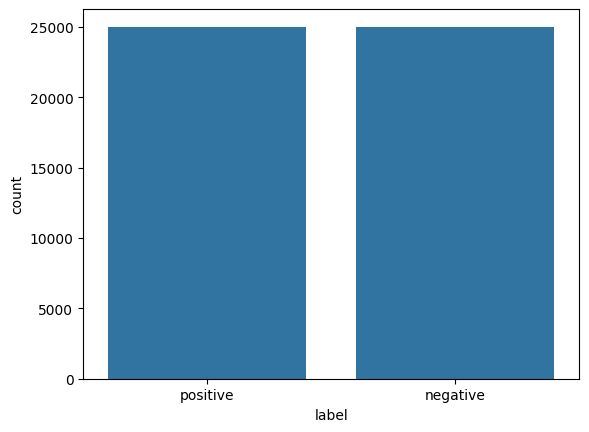

In [ ]:
sns.countplot( x = 'label', data = df );

In [ ]:
import re
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import csv
def load_stopwords_from_csv(csv_file):
    stopwords = set()
    with open(csv_file, newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            stopwords.add(row[0])
    return stopwords

stopwords_csv_file = file_path+'/urdu_stopwords.csv'
urdu_stopwords = load_stopwords_from_csv(stopwords_csv_file)
print("Loaded Urdu Stopwords: ", len(urdu_stopwords))


Loaded Urdu Stopwords:  140


In [ ]:
def clean_text(urdu_text):
    urdu_text = urdu_text.lower()
    urdu_text = re.sub("[^\u0600-\u06FF\s]", ' ', urdu_text)
    urdu_text = nltk.word_tokenize(urdu_text)
    urdu_text = [t for t in urdu_text if len(t) > 1]
    urdu_text = [stemmer.stem(word) for word in urdu_text if word not in urdu_stopwords]
    urdu_text = ' '.join(urdu_text)
    return urdu_text

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
!pip install Urduhack[tf]
# !pip install Urduhack[tf-gpu]


In [ ]:
import urduhack

# Downloading models
urduhack.download()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


89078/89078 [==============================] - 0s 0us/step


In [ ]:
from urduhack.preprocessing import normalize_whitespace
from urduhack.normalization import normalize
from urduhack.tokenization import sentence_tokenizer
from urduhack.tokenization import word_tokenizer
from urduhack.preprocessing import remove_punctuation
from urduhack.preprocessing import replace_numbers
from urduhack.preprocessing import remove_english_alphabets

In [ ]:
import re
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def preprocess_urdu_text(text):
    text = remove_emojis(text)
    text = normalize_whitespace(text)
    text = remove_punctuation(text)
    text = replace_numbers(text)
    text = remove_english_alphabets(text)
    text = normalize(text)
    return text

df['preprocessed_text'] = df['text'].apply(preprocess_urdu_text)

In [ ]:
urdu_texts = df['preprocessed_text'].values
len(urdu_texts)

50000

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the Urdu text data
tokenizer.fit_on_texts(urdu_texts)

# Tokenize the text data
urdu_sequences = tokenizer.texts_to_sequences(urdu_texts)

max_seq_length = max(len(seq) for seq in urdu_sequences)
padded_sequences = pad_sequences(urdu_sequences, maxlen=max_seq_length, padding='post')

In [ ]:
token = pd.DataFrame(tokenizer.word_counts.items(), columns=['word', 'count'])

token.head(8)

,word,count


In [ ]:
!unzip /content/drive/MyDrive/urduvec_140M_100K_300d.zip

Archive:  /content/drive/MyDrive/urduvec_140M_100K_300d.zip
  inflating: urduvec_140M_100K_300d.bin  


In [ ]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("/content/urduvec_140M_100K_300d.bin", binary=True)

In [ ]:
import numpy as np
embedding_dim = word2vec_model.vector_size
vocab_size = len(word2vec_model)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in enumerate(word2vec_model.index_to_key):
    embedding_matrix[i] = word2vec_model.get_vector(word)

In [ ]:
pretrained_vocab = set(word2vec_model.index_to_key)
oov_words = [word for word in token['word'].tolist() if word not in pretrained_vocab]

print("Out-of-vocabulary words:", oov_words)


Out-of-vocabulary words: []


In [ ]:
print("Out-of-vocabulary words:", len(oov_words))


Out-of-vocabulary words: 0


In [ ]:
overlapping_words = [word for word in token['word'].tolist() if word in pretrained_vocab]

print("len of overlapping_words words:", len(overlapping_words))
print("overlapping_words words:", overlapping_words)


len of overlapping_words words: 0
overlapping_words words: []


In [ ]:
labels = df['label'].values

In [ ]:
print(len(word2vec_model))
len(token)

102214


102201

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame containing the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])  # 'label' is the column containing your string labels

# Then use encoded_labels in your model

label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(label_mapping)

{0: 'negative', 1: 'positive'}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, sequences, labels):
    predictions = model.predict(sequences)
    predicted_classes = np.round(predictions)
    accuracy = accuracy_score(labels, predicted_classes)
    precision = precision_score(labels, predicted_classes, zero_division=1)
    recall = recall_score(labels, predicted_classes)
    f1 = f1_score(labels, predicted_classes)
    return accuracy, precision, recall, f1


In [ ]:
trainData, testData, trainTarget, testTarget = train_test_split(padded_sequences, encoded_labels, test_size=0.25, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense, Dropout
from keras.preprocessing.text import Tokenizer


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

model.add(Bidirectional(LSTM(units = 64, dropout = 0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units = 64, dropout = 0.2, return_sequences=True)))

model.add(Bidirectional(LSTM(units = 64, dropout = 0.2)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


1172/1172 [==============================] - 664s 549ms/step - loss: 0.6528 - accuracy: 0.6085 - val_loss: 0.6817 - val_accuracy: 0.5060


In [ ]:
model.fit(trainData, trainTarget, validation_data = (testData, testTarget), epochs = 1, batch_size = 32)


# accuracy, precision, recall, f1 = evaluate_model(model, testData, testTarget)
# score = ['BiLSTM', 2, 0.2, accuracy, precision, recall, f1]

# results = pd.DataFrame([score], columns = ['Model', 'Layers', 'Dropout Rate', 'Accuracy', 'Precision', 'Recall', 'F1'])

1172/1172 [==============================] - 646s 551ms/step - loss: 0.3924 - accuracy: 0.8231 - val_loss: 0.3762 - val_accuracy: 0.8288


In [ ]:
# Saving our model results for future use
modelData = {
    'tokenizer': tokenizer,
    'max_seq_length': max_seq_length,
    'model': model
}

import pickle
with open('urduSentiModel', 'wb') as file:
    pickle.dump(modelData, file)

In [ ]:
# Predicting the sentiment of a new review
def predict_sentiment(review):
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_length, padding='post')
    prediction = model.predict(padded_sequence)
    return np.round(prediction[0])



In [ ]:
accuracy, precision, recall, f1 = evaluate_model(model, testData, testTarget)
score = ['BiLSTM', 3, 0.3, accuracy, precision, recall, f1]
results = pd.DataFrame([score], columns = ['Model', 'Layers', 'Dropout Rate', 'Accuracy', 'Precision', 'Recall', 'F1'])
results

In [ ]:
predictions = model.predict(padded_sequences)
predictions = np.round(predictions)

1563/1563 [==============================] - 314s 201ms/step


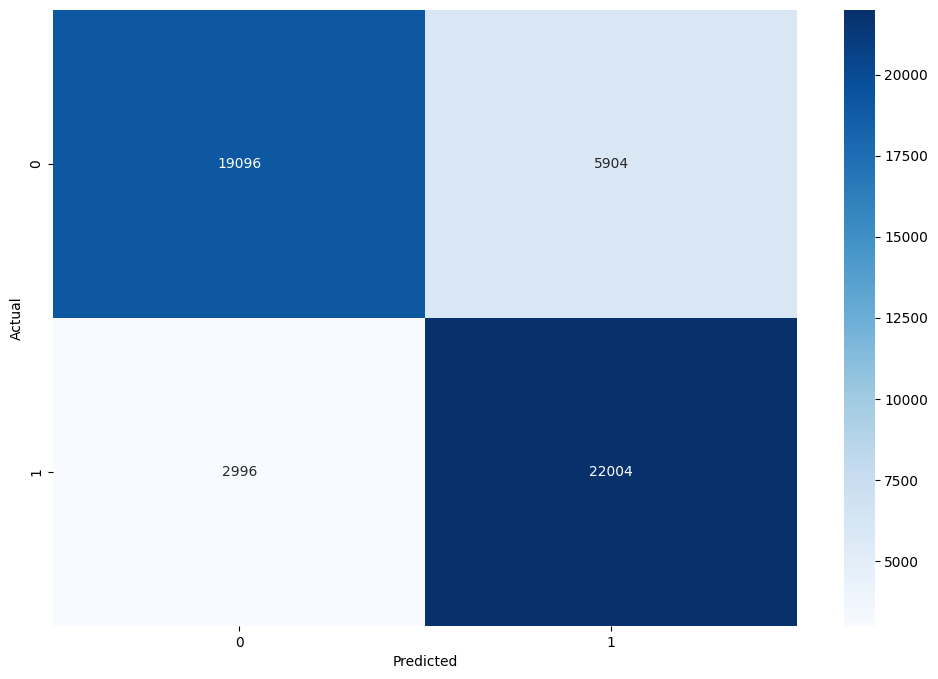

In [ ]:

# Generate graph of confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(encoded_labels, predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Give some examples of the model's predictions where the model incorrectly predicted 1
incorrect_predictions = df[(encoded_labels == 1) & (predictions.flatten() == 0)]
incorrect_predictions.head()


,text,label,preprocessed_text
5,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...,positive,یہ کولمبو ہے جس کی ہدایتکاری اپنے کیریئر کے اب...
7,ٹھیک ہے ، شاید یہ آسکر کا مستحق نہیں ہے۔ یا گو...,positive,ٹھیک ہے شاید یہ آسکر کا مستحق نہیں ہے یا گولڈ...
45,واقعی پریشان کن ہوتا ہے جب اس جیسی اچھی فلمیں ...,positive,واقعی پریشان کن ہوتا ہے جب اس جیسی اچھی فلمیں ...
66,سچ ہے ، یہ کتاب کی بہت قریب سے پیروی نہیں کرتی...,positive,سچ ہے یہ کتاب کی بہت قریب سے پیروی نہیں کرتی ...
79,اس فلم میں وہ سب کچھ موجود ہے جو ایک خراب فلم ...,positive,اس فلم میں وہ سب کچھ موجود ہے جو ایک خراب فلم ...


In [ ]:
report = classification_report(encoded_labels, predictions, target_names=label_mapping.values())
print(report)

              precision    recall  f1-score   support

    negative       0.86      0.76      0.81     25000
    positive       0.79      0.88      0.83     25000

    accuracy                           0.82     50000
   macro avg       0.83      0.82      0.82     50000
weighted avg       0.83      0.82      0.82     50000

